# Random forest classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution.

## 1. Data acquisition

In [ ]:
# Handle imports up-front
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform, norm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

### 1.1. Load the data

In [2]:
# Load the data from the URL
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')

### 1.2. Inspect the data

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### 1.3. Prepare the data

In [4]:
# Separate features from labels
labels=data_df['Outcome']
features=data_df.drop('Outcome', axis=1)

# Split the data into training and testing features and labels
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.25,
    random_state=315
)

## 2. EDA

### 2.1. Inspect data distributions

Since all of our features appear to be discrete or continuous random variables, a good place to start is looking at their distributions.

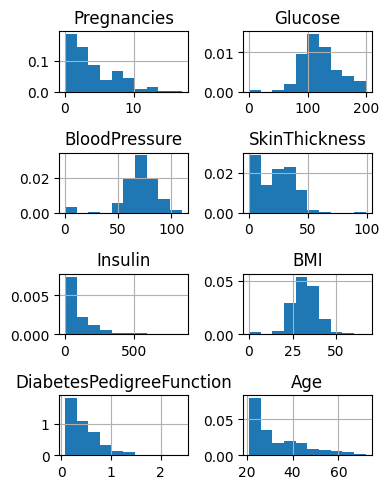

In [5]:
training_features.hist(density=True, layout=(4,2), figsize=(4,5))
plt.tight_layout()
plt.show()

We can also better understand the feature distributions by looking at some summary statistics:

In [6]:
training_features.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,3.836806,120.604167,69.524306,21.338542,84.321181,32.215451,0.471531,33.168403
std,3.416752,31.320885,17.973587,16.136967,122.042114,7.759484,0.337386,11.745613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.500000,0.238000,24.000000
50%,3.000000,117.000000,72.000000,24.000000,39.000000,32.400000,0.367000,29.000000
75%,6.000000,138.000000,80.000000,33.000000,130.000000,36.600000,0.626750,41.000000
max,17.000000,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,72.000000


### 2.2. Missing data

From the histograms and the summary statistics table, it is pretty clear that we have zeros in features where it doesn't make sense. For example, blood pressure or skin thickness cannot be zero. The zeros are most likely placeholders for missing data. We may be able to improve our classifier's performance by getting rid of some (or all) of the zeros somehow. 

There are many ways to approach dealing with missing data - there is not one 'best' or 'right' way. Will have to do an experiment, or series of experiments to determine what works best for this dataset. For every method we try, we need a standard of comparison to evaluate the methods's effectiveness. Remember - the only reason to do any EDA or feature engineering at all is to improve our model's performance or reliability. The goal is always to make the best model we can.

So, first thing's first - we need to establish a baseline estimate of performance using cross-validation.

#### 2.2.1. Baseline performance estimate

In [7]:
# Define a reusable helper function for cross-validation here. We are going to
# be doing a lot of cross-validation, this allows us to reuse this code
# without having to copy-paste it over and over.

def cross_val(features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on random forest 
    classifier with Scikit-learn defaults. Takes Pandas data frame of features
    and Pandas data series of labels. Returns list of cross-validation fold 
    accuracy scores as percents.'''

    # Instantiate a random forest classifier model
    model=RandomForestClassifier(random_state=315)

    # Define the cross-validation strategy
    cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='accuracy'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross-validation accuracy: {(scores.mean() * 100):.2f} +/- {(scores.std() * 100):.2f}%')

    # Return the scores
    return scores

scores=cross_val(training_features, training_labels)

Cross-validation accuracy: 76.03 +/- 3.61%


#### 2.2.1. Zero removal by feature drops

From the histograms above, it's pretty clear that some features have many zeros, while some only have a few. For other features, like *pregnancies*, it's not unexpected to have zeros at all. Let's take a look at how many zeros we have in each feature and try getting rid of one or a few features with the most zeros -  and then see if that improves the classifier's performance.

In [8]:
(training_features == 0).sum(axis=0)

Pregnancies                  88
Glucose                       4
BloodPressure                21
SkinThickness               161
Insulin                     276
BMI                           7
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

Ok, so, excluding pregnancies, we can get rid of the majority of zeros by dropping *SkinThickness* and *Insulin*:

In [9]:
selected_training_features=training_features.drop(['SkinThickness', 'Insulin'], axis=1)
selected_training_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, 10 to 611
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               576 non-null    int64  
 1   Glucose                   576 non-null    int64  
 2   BloodPressure             576 non-null    int64  
 3   BMI                       576 non-null    float64
 4   DiabetesPedigreeFunction  576 non-null    float64
 5   Age                       576 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 31.5 KB


Now, evaluate the performance and see if dropping the features helped.

In [10]:
scores=cross_val(selected_training_features, training_labels)

Cross-validation accuracy: 76.04 +/- 2.71%


Nope didn't help - almost exactly the same mean accuracy as baseline, though the variability between the cross-validation folds did go down somewhat. At this point we have two choices, we can leave the zeros alone and move on to something else, or we can try another method.

## 3. Hyperparameter optimization

At this point, we should be satisfied that we have looked at the data every which-way we can think of and exhausted all of our tricks to clean and improve it. Once we have accomplished that, it's time to take our shiny new dataset and move on the optimizing the model. The main approach for us here will be hyperparameter optimization. But, be aware that data scientists often test different types of models (i.e. try logistic regression vs random forest) to see which works best for a given problem.

Take a look at the documentation for the model and pick a few hyperparameters to optimize. Then use grid search or random search to find the best values. Grid search works best for hyperparameters that are categorical or discrete while random search is better for continuous valued hyperparameters.

In [17]:
import warnings
warnings.filterwarnings('ignore')

# Define the hyperparameter distributions to sample from
distributions={
    'n_estimators': list(range(2, 100)),
    'max_depth': list(range(3, 100)) + [None],
    'min_samples_split': list(range(2, 10)),
    'min_samples_leaf': list(range(1, 10)),
}

# Instantiate a random forest classifier model
model=RandomForestClassifier(random_state=315)

# Define the cross-validation strategy
cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

# Set-up the grid search
grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cross_validation,
    n_iter=100,
    random_state=315,
    return_train_score=True
)

# Run the grid search
results=grid.fit(training_features, training_labels)

# Print the best parameter settings found at the end
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'n_estimators': 59, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 32}


Note: the optimization came up with different values for these hyperparameters than the Scikit-learn default settings! Now we can use the winning values to train and evaluate our final model.

In [12]:
# Instantiate a model using the winning parameters
model=RandomForestClassifier(
    n_estimators=results.best_params_['n_estimators'],
    min_samples_split=results.best_params_['min_samples_split'],
    min_samples_leaf=results.best_params_['min_samples_leaf'],
    max_depth=results.best_params_['max_depth'],
    random_state=315
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    training_features,
    training_labels,
    cv=cross_validation,
    n_jobs=-1,
    scoring='accuracy'
)

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 77.4 +/- 2.0%


Nice! We improved the mean cross-validation performance by more than a percentage point. Now we can move on to the final evaluation with the test data set.

## 4. Evaluation

In [13]:
# Instantiate a model using the winning parameters
model=RandomForestClassifier(
    n_estimators=results.best_params_['n_estimators'],
    min_samples_split=results.best_params_['min_samples_split'],
    min_samples_leaf=results.best_params_['min_samples_leaf'],
    max_depth=results.best_params_['max_depth'],
    random_state=315
)

# Train the model on the complete training data set
fit_result=model.fit(training_features, training_labels)

# Make predictions from test set features
predicted_labels=model.predict(testing_features)

# Score predictions for accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels)  * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 76.0% accurate on the test data


## 5. A note on interpretation & some statistics

As a professional data scientist, in addition to making the model as accurate as possible, we want to have a good estimate of how accurate it will be on un-seen test data. With our cross-validation results, we can take advantage of some simple statistics to talk about probabilities and confidence intervals. The first useful thing to look at is a confidence interval around the cross-validation performance:

In [14]:
lower_bound, upper_bound=norm.interval(0.95, loc=scores.mean(), scale=scores.std())
print(f'95% CI = {lower_bound*100:.1f}% - {upper_bound*100:.1f}% accuracy')

95% CI = 73.4% - 81.4% accuracy


We can also use SciPy's stats module to calculate the probability of the test set result we observed, given our cross-validation results. Doing so will give us a nice way to quantify how well we are estimating true out-of-sample performance. If our test score is likely, we are in good shape. If the test result is very unlikely then something is probably wrong.

In [15]:
z_score=((percent_accuracy/100) - scores.mean()) / scores.std()
probability=norm.pdf(z_score)

print(f'Probability: {probability*100:.1f}%')

Probability: 31.7%


For example - what would happen if our test result was only 72% accurate - just outside of our 95% confidence interval?

In [16]:
percent_accuracy=70
z_score=((percent_accuracy/100) - scores.mean()) / scores.std()
probability=norm.pdf(z_score)
print(f'Probability: {probability*100:.1f}%')

Probability: 0.1%
